In [1]:
import math
import warnings

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pof
import plotly.io as pio
import scipy
import seaborn as seaborn
from matplotlib import pyplot as plt
from plotly.subplots import make_subplots
from sklearn.preprocessing import LabelEncoder

pof.init_notebook_mode()
pio.renderers.default = "svg"


def set_up_printing():
    """Sets up display parameters"""

    max_dimensions_display_limit = 1000
    pd.set_option('display.max_columns', max_dimensions_display_limit)
    pd.set_option('display.max_colwidth', None)

    pd.set_option('display.max_rows', max_dimensions_display_limit)
    pd.set_option('display.width', None)

    pd.set_option('display.max_info_columns', max_dimensions_display_limit)
    pd.set_option('display.max_info_rows', max_dimensions_display_limit)

    warnings.filterwarnings('ignore')


def missing_percent(data, total):
    return data.isnull().sum() / total * 100


def fix_nan_values(dataframe, limit):
    print(dataframe.isnull().sum())

    for column in dataframe.columns:
        percent = missing_percent(dataframe[column], dataframe.shape[0])

        # сравниваем с пороговым значением заданным экспертно
        if limit > percent > 0:
            print(
                'Требуется проанализировать баланс значений целевого признака, в столбце ' + column + ' обнаружены пустые значения:')
            print('- всего обнаружено NaN пустых значений, в процентах от всего набора:', round(percent, 2), '%')

        if percent >= limit:
            print('Столбец ' + column + ' будет удален, значительное число Nan значений:')
            print('- всего было NaN значений, в процентах от всего набора:', round(percent, 2), '%')

            dataframe = dataframe.drop(column, axis=1)

    print('\n')

    return dataframe


def clear(dataframe):
    target_balance(dataframe,
                   'Баланс целевого признака до очистки данных от пустых значений, неинформативных признаков, выбросов и дубликатов:')

    info_aux_and_nans(dataframe, 'До очистки от NaN значений:')
    dataframe = fix_nan_values(dataframe, 3)
    info_aux_and_nans(dataframe, 'После очистки от NaN значений:')

    print('NaN значений в наборе - не найдено.', '\n')

    shape(dataframe, 'До очистки от дубликатов:')
    dataframe = dataframe.drop_duplicates()
    shape(dataframe, 'После очистки от дубликатов:')

    print('Дубликатов рядов в наборе - не найдено.', '\n')

    info_aux(dataframe, 'До очистки от низкоинформативных столбцов:')
    dataframe = drop_low_informative(dataframe)
    info_aux(dataframe, 'После очистки от низкоинформативных столбцов:')

    # Удалим выбросы по методу IQR, увеличим интервал, величина задана экспертно
    shape(dataframe, 'До очистки от выбросов:')
    non_object_column_names = list(dataframe.select_dtypes(exclude=['object']).columns)

    non_object_and_non_boolean_column_names = []
    for name in non_object_column_names:
        if dataframe[name].unique().tolist() != ([1, 0]):
            non_object_and_non_boolean_column_names.append(name)

    # задаем выше 1.5, экспертно, чтобы сохранить больше значений из-за несбалансированности
    i = 3
    for name in non_object_and_non_boolean_column_names:
        Q25 = dataframe[name].quantile(0.25)
        Q75 = dataframe[name].quantile(0.75)
        iqr = Q75 - Q25
        dataframe = dataframe[dataframe[name] >= Q25 - i * iqr]
        dataframe = dataframe[dataframe[name] <= Q75 + i * iqr]
        shape(dataframe, 'баланс после очистки для столбца ' + name + " :")

    shape(dataframe, 'После очистки от выбросов:')

    # проверим, что нет критических изменений в балансе после очистки, также стремимся сохраненить абсолютное цисло признака с меньшей долей
    target_balance(dataframe,
                   'Баланс целевого признака после очистки данных от пустых значений, неинформативных признаков, выбросов и дубликатов:')

    print('\n')

    return dataframe


def drop_low_informative(dataframe):
    low_information_cols = get_low_informative(dataframe, 0.9)

    print('Исходя из содержания столбцов, мы можем удалить столбецы RowNumber,CustomerId, Surname', '\n')
    dataframe = dataframe.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
    return dataframe


def get_low_informative(dataframe, limit):
    low_information_cols = []

    for col in dataframe.columns:
        # наибольшая относительная частота значения признака
        top_freq = dataframe[col].value_counts(normalize=True).max()
        # доля уникальных значений признака
        nunique_ratio = dataframe[col].nunique() / dataframe[col].count()
        # сравниваем с пороговым значением заданным экспертно
        if top_freq > limit:
            print(f'{col}: {round(top_freq * 100, 2)}% одинаковых значений')
            low_information_cols.append(col)
        # сравниваем долю уникальных значений с порогом
        if nunique_ratio > limit:
            print(f'{col}: {round(nunique_ratio * 100, 2)}% уникальных значений')
            low_information_cols.append(col)

    return low_information_cols


def info_aux(dataframe, message):
    print(message, '\n')
    dataframe.info()
    print('\n')


def info_aux_and_nans(dataframe, message):
    print(message, '\n')
    dataframe.info()
    dataframe.isnull().sum()
    print('\n')


def shape(dataframe, message):
    print(message, '\n')
    print(' - размерность набора данных - ', dataframe.shape)
    print('\n')


def info_aux_and_head(dataframe, message):
    print(message, '\n')
    dataframe.info()
    print(dataframe.head(3))
    print('\n')


def target_balance(dataframe, message):
    print(message, '\n')
    print(dataframe['Exited'].value_counts())
    print('\n')

# настроим отображение при выводе в консоль
set_up_printing()

# считаем данные и одновременно удалим пустые строки
dataframe = pd.read_csv(r'C:\Users\kM\Downloads\churn\churn.csv', skip_blank_lines=True)

# очистим данные от пустых значений, неинформативных признаков, выбросов и дубликатов
dataframe = clear(dataframe)

Баланс целевого признака до очистки данных от пустых значений, неинформативных признаков, выбросов и дубликатов: 

0    7963
1    2037
Name: Exited, dtype: int64


До очистки от NaN значений: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Dtype  
---  ------           -----  
 0   RowNumber        int64  
 1   CustomerId       int64  
 2   Surname          object 
 3   CreditScore      int64  
 4   Geography        object 
 5   Gender           object 
 6   Age              int64  
 7   Tenure           int64  
 8   Balance          float64
 9   NumOfProducts    int64  
 10  HasCrCard        int64  
 11  IsActiveMember   int64  
 12  EstimatedSalary  float64
 13  Exited           int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure 

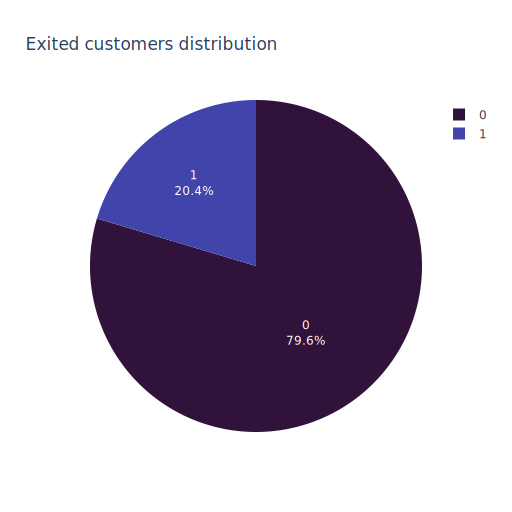

После очистки данных от пустых строк, значений, неинформативных признаков, выбросов и дубликатов
соотношение практически не изменилось, мы за этим следили,
поскольку в нашем случае изначально распределение целевого признака 
несбалансировано, следовательно повышается ценность для анализа
рядов с менее частым значением целевого признака.
Таким образом, очевидно то, что до обучения модели потребуется приложить больше
усилий например, собрать больше данных для менее частых рядов,
использовать метрику, менее чуствительную к несбалансированных данным (как F1),
скопировать/удалить менее/более частые ряды
или искусственно сгенерировать менее частые ряды



In [2]:
'''Задание 9.1'''
color_continuous_scale = px.colors.sequential.Turbo
counts = dataframe['Exited'].value_counts()
area_fig = px.pie(data_frame=dataframe, values=counts, names=counts.keys(),
                  title='Exited customers distribution', color_discrete_sequence=color_continuous_scale)
area_fig.update_traces(textposition='inside', textinfo='percent+label')
area_fig.update_layout(
    autosize=False,
    width=512,
    height=512,)
area_fig.show("svg")

print('После очистки данных от пустых строк, значений, неинформативных признаков, выбросов и дубликатов\n'
      'соотношение практически не изменилось, мы за этим следили,\n'
      'поскольку в нашем случае изначально распределение целевого признака \n'
      'несбалансировано, следовательно повышается ценность для анализа\n'
      'рядов с менее частым значением целевого признака.\n'
      'Таким образом, очевидно то, что до обучения модели потребуется приложить больше\n'
      'усилий например, собрать больше данных для менее частых рядов,\n'
      'использовать метрику, менее чуствительную к несбалансированных данным (как F1),\n'
      'скопировать/удалить менее/более частые ряды\n'
      'или искусственно сгенерировать менее частые ряды\n')


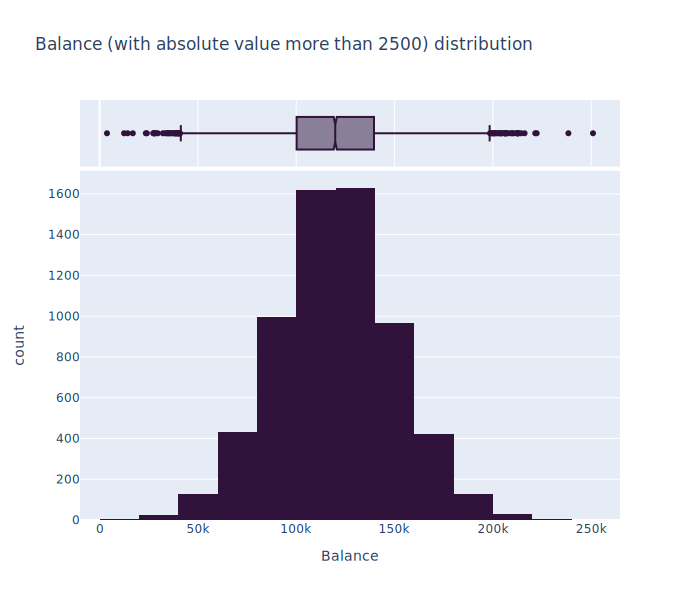

Тест на нормальность по коэффициенту ассиметрии, результат: True
Тест на нормальность по коэффициенту эксцесса, результат: False 

Вывод: распределение по форме напоминает колокол, схоже с нормальным;
при этом оно не проходит тест на нормальность по коэффициенту эксцесса, 
зато проходит тот же тест по коэффициенту ассиментрии; 
это дает возможность сходу заиспользовать данный признак 
в случае решения данной задачи методом регрессии, поскольку 
для данной методики есть требование нормальности распределения признаков;
есть и другие модели, которые могут давать лучшие результаты 
для нормального распределения.


In [3]:
'''Задание 9.2'''
balance_more_2500 = dataframe[dataframe['Balance'] > 2500]

# Самостоятельно настроим размер корзины, заиспользуем формулу Sturges (ссылка https://www.jstor.org/stable/2965501#metadata_info_tab_contents)
bin_width = int(math.log2(balance_more_2500.shape[0]) + 1) + 1
area_fig = px.histogram(data_frame=balance_more_2500, x='Balance',
                        title='Balance (with absolute value more than 2500) distribution',
                        marginal="box",
                        color_discrete_sequence=color_continuous_scale,
                        nbins=bin_width)
area_fig.update_layout(
    autosize=False,
    width=700,
    height=600,)
area_fig.show("svg")

is_skewtest_normal_test_passed = scipy.stats.skewtest(balance_more_2500['Balance'])[1] > 0.05
print('Тест на нормальность по коэффициенту ассиметрии, результат: ' + str(is_skewtest_normal_test_passed))
is_kurtosistest_normal_test_passed = scipy.stats.kurtosistest(balance_more_2500['Balance'])[1] > 0.05
print('Тест на нормальность по коэффициенту эксцесса, результат: ' + str(is_kurtosistest_normal_test_passed), '\n')

print('Вывод: распределение по форме напоминает колокол, схоже с нормальным;\n'
      'при этом оно не проходит тест на нормальность по коэффициенту эксцесса, \n'
      'зато проходит тот же тест по коэффициенту ассиментрии; \n'
      'это дает возможность сходу заиспользовать данный признак \n'
      'в случае решения данной задачи методом регрессии, поскольку \n'
      'для данной методики есть требование нормальности распределения признаков;\n'
      'есть и другие модели, которые могут давать лучшие результаты \n'
      'для нормального распределения.')


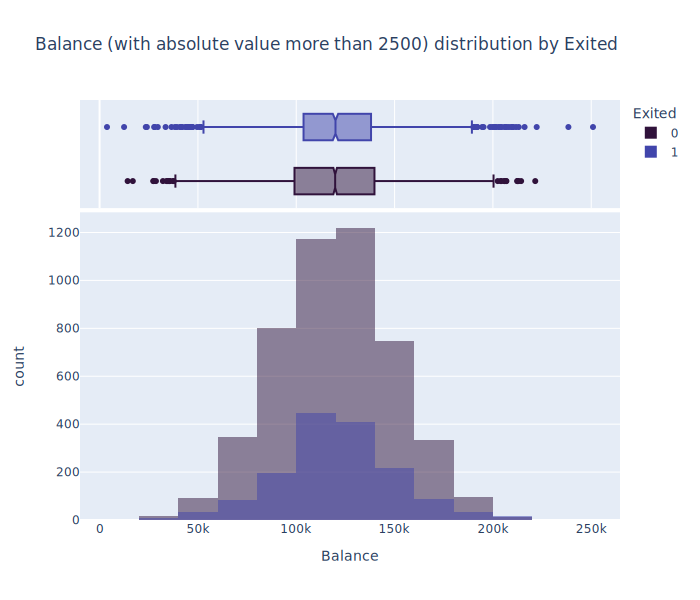

Тест на нормальность по коэффициенту ассиметрии для признака Balanced и текущих клиентов, результат: True
Тест на нормальность по коэффициенту эксцесса для признака Balanced и текущих клиентов, результат: True 

Тест на нормальность по коэффициенту ассиметрии для признака Balance и ушедших клиентов, результат: True
Тест на нормальность по коэффициенту эксцесса для признака Balance и ушедших клиентов, результат: False 

Вывод: с учетом того, что действительно существует факт социального неравенства 
и данные несбалансированы в пользу существующих клиентов, на мой взгляд, целесообразно оставить 
данные крайние значение для последующего анализа, а не удалять;
например, есть вероятность того, что крайние наблюдения относятся к части клиентов, которые требуют либо 
более премиального либо более низкого уровня сервиса

Подробные рассуждение далее. Распределения признака Balance как для ушедших, так и для действующих клиентов
по форме напоминает колокол, схоже с нормальным.
Как уже отмечалось

In [4]:
'''Задание 9.3'''
area_fig = px.histogram(data_frame=balance_more_2500, x='Balance',
                        hover_data=balance_more_2500.columns, color="Exited",
                        marginal="box",
                        barmode="overlay",
                        title='Balance (with absolute value more than 2500) distribution by Exited',
                        color_discrete_sequence=color_continuous_scale,
                        nbins=bin_width)
area_fig.update_layout(
    autosize=False,
    width=700,
    height=600,)
area_fig.show("svg")

balance_more_2500_current_customers = balance_more_2500[balance_more_2500['Exited'] == 0]['Balance']
is_skewtest_normal_test_passed = \
    scipy.stats.skewtest(balance_more_2500_current_customers)[1] > 0.05
print('Тест на нормальность по коэффициенту ассиметрии для признака Balanced и текущих клиентов, результат: ' + str(
    is_skewtest_normal_test_passed))
is_kurtosistest_normal_test_passed = \
    scipy.stats.kurtosistest(balance_more_2500_current_customers)[1] > 0.05
print('Тест на нормальность по коэффициенту эксцесса для признака Balanced и текущих клиентов, результат: ' + str(
    is_kurtosistest_normal_test_passed), '\n')

balance_more_2500_exited_customers = balance_more_2500[balance_more_2500['Exited'] == 1]['Balance']
is_skewtest_normal_test_passed = \
    scipy.stats.skewtest(balance_more_2500_exited_customers)[1] > 0.05
print('Тест на нормальность по коэффициенту ассиметрии для признака Balance и ушедших клиентов, результат: ' + str(
    is_skewtest_normal_test_passed))
is_kurtosistest_normal_test_passed = \
    scipy.stats.kurtosistest(balance_more_2500_exited_customers)[1] > 0.05
print('Тест на нормальность по коэффициенту эксцесса для признака Balance и ушедших клиентов, результат: ' + str(
    is_kurtosistest_normal_test_passed), '\n')

print('Вывод: с учетом того, что действительно существует факт социального неравенства \n'
      'и данные несбалансированы в пользу существующих клиентов, на мой взгляд, целесообразно оставить \n'
      'данные крайние значение для последующего анализа, а не удалять;\n'
      'например, есть вероятность того, что крайние наблюдения относятся к части клиентов, которые требуют либо \n'
      'более премиального либо более низкого уровня сервиса\n\n'
      'Подробные рассуждение далее. Распределения признака Balance как для ушедших, так и для действующих клиентов\n'
      'по форме напоминает колокол, схоже с нормальным.\n'
      'Как уже отмечалось выше, это дает возможность сходу заиспользовать данный признак \n'
      'в случае решения данной задачи методом регрессии и другими, которые \n'
      'требуют нормальности распределения признаков.\n\n'
      'С другой стороны, распределение Balance для ушедвих клиентов проваливает один тест \n'
      'на нормальность. Более того, для ушедших мы видим значительно больее число выбросов \n'
      'по критерию IQR, то есть можно далее более внимательно анализировать крайние значения \n'
      'для того, чтобы понять, действительно ли стоит убирать выбросы или нет. \n')

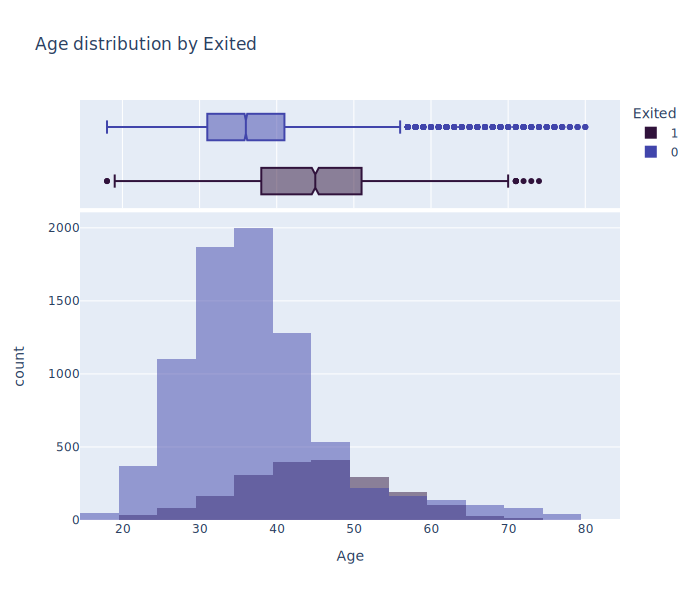

Тест на нормальность по коэффициенту ассиметрии для признака Aged и текущих клиентов, результат: False
Тест на нормальность по коэффициенту эксцесса для признака Aged и текущих клиентов, результат: False 

Тест на нормальность по коэффициенту ассиметрии для признака Age и ушедших клиентов, результат: True
Тест на нормальность по коэффициенту эксцесса для признака Age и ушедших клиентов, результат: False 

Вывод: более половины ушедших клиентов имеют возраст значимо больший, чем у 75% действующих, 
распределение возраста действующих клиентов имеет выраженную ассимметрию, в сторону 
более молодых клиентов, и, соответственно, больше "потенциальных выбросов" - в зрелом возрасте, следовательно, 
можно предположить то, что следует обратить внимание на группу с медианным возрастом в 45 лет.




In [5]:
'''Задание 9.4'''
area_fig = px.histogram(data_frame=dataframe, x='Age',
                        hover_data=dataframe.columns, color="Exited",
                        marginal="box",
                        barmode="overlay",
                        title='Age distribution by Exited',
                        color_discrete_sequence=color_continuous_scale,
                        nbins=bin_width)
area_fig.update_layout(
    autosize=False,
    width=700,
    height=600,)
area_fig.show("svg")

age_current_customers = dataframe[dataframe['Exited'] == 0]['Age']
is_skewtest_normal_test_passed = \
    scipy.stats.skewtest(age_current_customers)[1] > 0.05
print('Тест на нормальность по коэффициенту ассиметрии для признака Aged и текущих клиентов, результат: ' + str(
    is_skewtest_normal_test_passed))
is_kurtosistest_normal_test_passed = \
    scipy.stats.kurtosistest(age_current_customers)[1] > 0.05
print('Тест на нормальность по коэффициенту эксцесса для признака Aged и текущих клиентов, результат: ' + str(
    is_kurtosistest_normal_test_passed), '\n')

age_exited_customers = dataframe[dataframe['Exited'] == 1]['Age']
is_skewtest_normal_test_passed = \
    scipy.stats.skewtest(age_exited_customers)[1] > 0.05
print('Тест на нормальность по коэффициенту ассиметрии для признака Age и ушедших клиентов, результат: ' + str(
    is_skewtest_normal_test_passed))
is_kurtosistest_normal_test_passed = \
    scipy.stats.kurtosistest(age_exited_customers)[1] > 0.05
print('Тест на нормальность по коэффициенту эксцесса для признака Age и ушедших клиентов, результат: ' + str(
    is_kurtosistest_normal_test_passed), '\n')

print('Вывод: более половины ушедших клиентов имеют возраст значимо больший, чем у 75% действующих, \n'
      'распределение возраста действующих клиентов имеет выраженную ассимметрию, в сторону \n'
      'более молодых клиентов, и, соответственно, больше "потенциальных выбросов" - в зрелом возрасте, следовательно, \n'
      'можно предположить то, что следует обратить внимание на группу с медианным возрастом в 45 лет.\n\n')


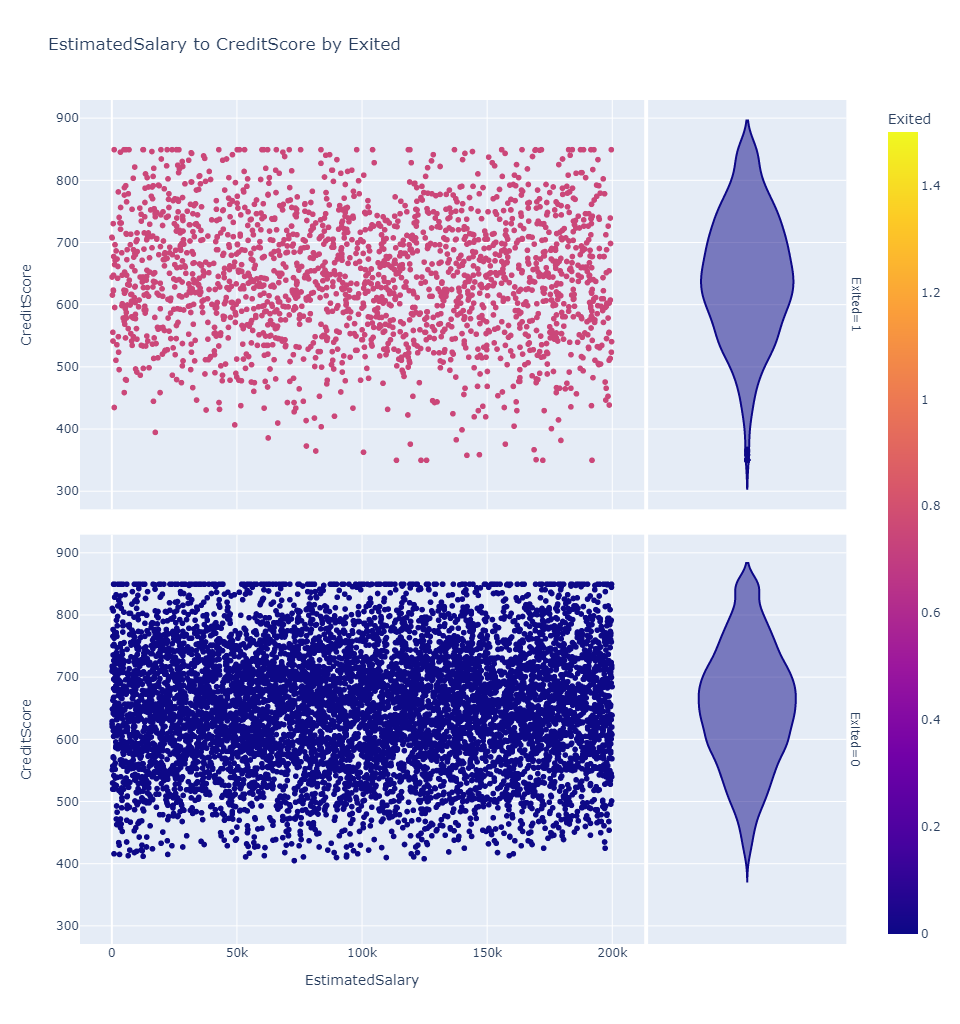

Вывод: можно предположить то, что:
- оценка кредитного рейтинга имеет через-чур много максимальных рейтингов, при этом потенциальное
завышение рейтингов чаще у действующих клиектов, чем у ушедших это видно из KDE (Ядерная оценка плотности,
 использована как альтернатива гистограмме, поскольку позволяет измежать выбора ширины корзины и сглажена);
- также можно допустить то, что реализованная методика оценки запрлаты не информативна, поскольку
по сути мы видим случайное распределение оценки зарплат, что отлично от общепринятого воззрения на
существование среднего класса и распределения доходов; этом прочие наблюдаемые зависимости распределения
показателя оттока от кредитного рейтинга и оценки запралты крайне схожи.




In [6]:
'''Задание 9.5'''
area_fig = px.scatter(data_frame=dataframe, x='EstimatedSalary',
                      y='CreditScore',
                      hover_data=dataframe.columns,
                      marginal_y="violin",
                      color="Exited",
                      facet_row="Exited",
                      title='EstimatedSalary to CreditScore by Exited',
                      color_discrete_sequence=color_continuous_scale)
area_fig.update_layout(
    autosize=False,
    width=960,
    height=1024,)
area_fig.show("png")

print('Вывод: можно предположить то, что:\n'
      '- оценка кредитного рейтинга имеет через-чур много максимальных рейтингов, при этом потенциальное\n'
      'завышение рейтингов чаще у действующих клиектов, чем у ушедших это видно из KDE (Ядерная оценка плотности,\n'
      ' использована как альтернатива гистограмме, поскольку позволяет измежать выбора ширины корзины и сглажена);\n'
      '- также можно допустить то, что реализованная методика оценки запрлаты не информативна, поскольку\n'
      'по сути мы видим случайное распределение оценки зарплат, что отлично от общепринятого воззрения на\n'
      'существование среднего класса и распределения доходов; этом прочие наблюдаемые зависимости распределения\n'
      'показателя оттока от кредитного рейтинга и оценки запралты крайне схожи.\n\n')


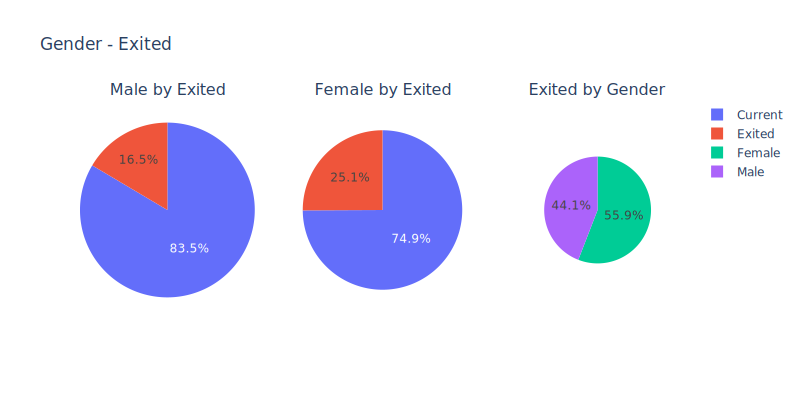

Вывод: как видно, 25% женщин-клиентов ушли, при этом от всем мужчин ушло ~17%, при этом ~56% от всех
ушедших - женского пола, т.е. чаще уходят женщины.




In [7]:
'''Задание 9.6'''
male_exited = dataframe[(dataframe['Exited'] == 1) & (dataframe['Gender'] == 'Male')].shape[0]
male_total = dataframe[(dataframe['Gender'] == 'Male')].shape[0]
female_exited = dataframe[(dataframe['Exited'] == 1) & (dataframe['Gender'] == 'Female')].shape[0]
female_total = dataframe[(dataframe['Gender'] == 'Female')].shape[0]

labels_by_exited = ["Exited", "Current"]
labels_by_gender = ["Male", "Female"]

fig = make_subplots(1, 3, specs=[[{'type': 'domain'}, {'type': 'domain'}, {'type': 'domain'}]],
                    subplot_titles=['Male by Exited', 'Female by Exited', 'Exited by Gender'])
fig.add_trace(go.Pie(labels=labels_by_exited, values=[male_exited, male_total - male_exited], scalegroup='one',
                     name="Male by Exited"), 1, 1)
fig.add_trace(
    go.Pie(labels=labels_by_exited, values=[female_exited, female_total - female_exited], scalegroup='one',
           name="Female by Exited"), 1, 2)
fig.add_trace(go.Pie(labels=labels_by_gender, values=[male_exited, female_exited], scalegroup='one',
                     name="Exited by Gender"), 1, 3)
fig.update_layout(
    title_text='Gender - Exited',
    autosize=False,
    width=800,
    height=400)
fig.show("svg")

print('Вывод: как видно, 25% женщин-клиентов ушли, при этом от всем мужчин ушло ~17%, при этом ~56% от всех\n'
      'ушедших - женского пола, т.е. чаще уходят женщины.\n\n')

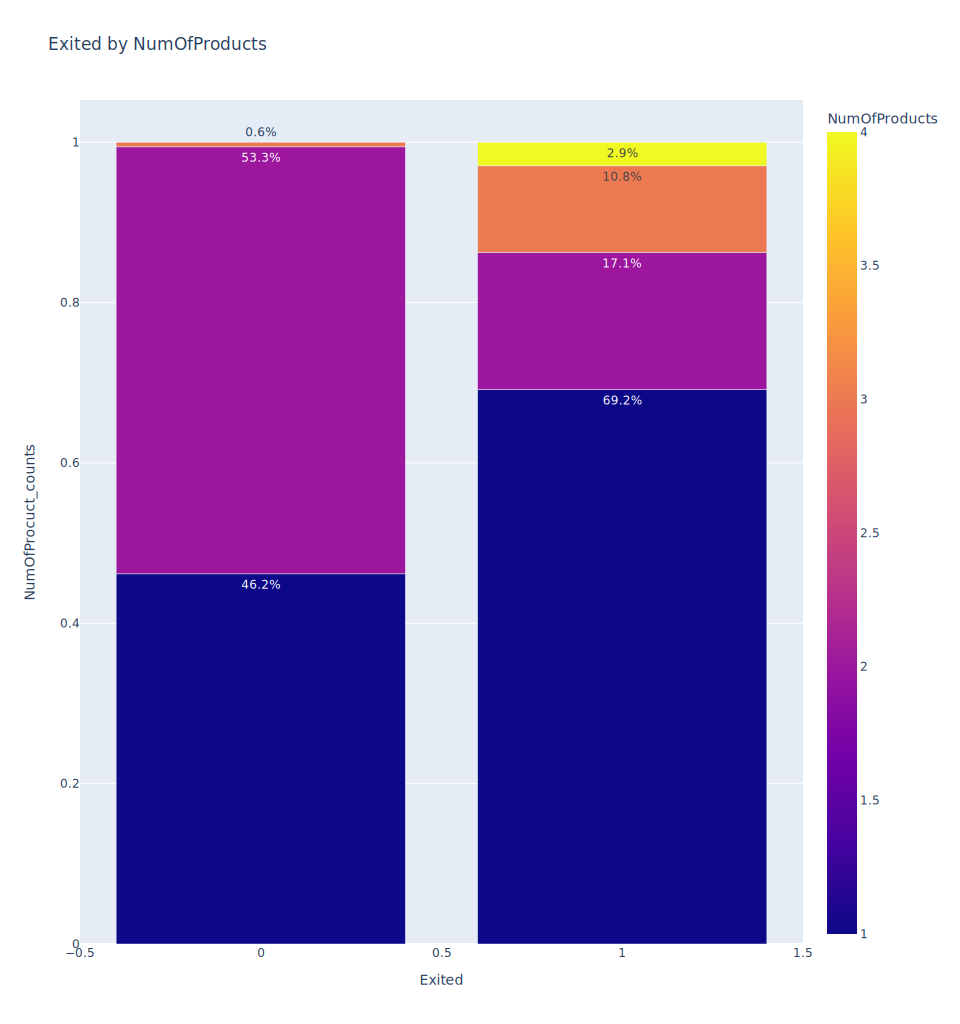

Вывод: как видно, большую часть ушедших клиентов составляли пользовавшиеся одним продуктом,
и при этом ~13% пользовались более чем двумя продуктами, действующие же клиенты пользуются в основном
двумя продуктами или одним, а более чем двумя - менее одного процента.
Можно предположить, что удаление продукта или уменьшение ассортимента продуктов могло повлиять
на решение уйти.




In [8]:
'''Задание 9.7'''
exited_num_of_products = dataframe[dataframe['Exited'] == 1]['NumOfProducts'].value_counts(normalize=True)
exited_num_of_products = pd.DataFrame({'NumOfProcuct_counts': exited_num_of_products}).sort_index()
exited_num_of_products['Exited'] = 1
current_num_of_products = dataframe[dataframe['Exited'] == 0]['NumOfProducts'].value_counts(normalize=True)
current_num_of_products = pd.DataFrame({'NumOfProcuct_counts': current_num_of_products}).sort_index()
current_num_of_products['Exited'] = 0
exited_current_num_of_products = pd.concat([exited_num_of_products, current_num_of_products], join='outer')
exited_current_num_of_products = exited_current_num_of_products.reset_index()
exited_current_num_of_products.rename(columns={'index': 'NumOfProducts'}, inplace=True)
exited_current_num_of_products['NumOfProcuct_counts_percentage'] = exited_current_num_of_products[
    'NumOfProcuct_counts'].apply(
    lambda x: str(round(100 * x, 1)) + '%')

fig = px.bar(exited_current_num_of_products, x="Exited", y="NumOfProcuct_counts", color="NumOfProducts",
             text='NumOfProcuct_counts_percentage',
             title="Exited by NumOfProducts")
fig.update_layout(
    autosize=False,
    width=960,
    height=1024)
fig.show("svg")

print('Вывод: как видно, большую часть ушедших клиентов составляли пользовавшиеся одним продуктом,\n'
      'и при этом ~13% пользовались более чем двумя продуктами, действующие же клиенты пользуются в основном\n'
      'двумя продуктами или одним, а более чем двумя - менее одного процента.\n'
      'Можно предположить, что удаление продукта или уменьшение ассортимента продуктов могло повлиять\n'
      'на решение уйти.\n\n')
